In [1]:
import statistics
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import scipy.stats as stats
#import tabulate
from matplotlib.patches import Ellipse

import pandas as pd 


sample_sizes = [20, 60, 100]
rhos = [0, 0.5, 0.9]
mean = [0, 0]
tests_repetition_number = 1000


def get_random_variables_value(sample_size, cov, is_mixed):
    # Generates a 2D array
    if is_mixed:
        return 0.9 * stats.multivariate_normal.rvs(mean, [[1, 0.9], [0.9, 1]], sample_size) \
             + 0.1 * stats.multivariate_normal.rvs(mean, [[10, -9], [-9, 10]], sample_size)
    return stats.multivariate_normal.rvs(mean, [[1, cov], [cov, 1]], sample_size)


def calc_quadrant_corr_coef(x, y):
    med_x = np.median(x)
    med_y = np.median(y)
    return np.mean(np.sign(x - med_x) * np.sign(y - med_y))


def get_coefficients_list(sample_size, cov, is_mixed):
    """
    Generates sample <tests_repetition_numer> times and
    calculates Pearson, Spearman, quadrant coefficients for this sample and writes them into lists
    """
    pearson_coefs = []
    spearman_coefs = []
    quadrant_coefs = []
    for _ in range(tests_repetition_number):
        sample = get_random_variables_value(sample_size, cov, is_mixed)
        x, y = sample[:, 0], sample[:, 1]
        pearson_coefs.append(stats.pearsonr(x, y)[0])
        spearman_coefs.append(stats.spearmanr(x, y)[0])
        quadrant_coefs.append(calc_quadrant_corr_coef(x, y))
    
    coefs = np.array([pearson_coefs, spearman_coefs, quadrant_coefs]) 
    mean = np.mean(coefs, axis = 1)
    square_mean = np.mean(coefs ** 2, axis=1)
    std = np.sqrt(square_mean - mean ** 2)
    return pd.DataFrame({'mean': mean, 'square_mean' : square_mean, 'std' : std}
                        , index= ['pearson', 'spearman', 'quadrant'])
    

In [24]:
print(np.round(get_coefficients_list(100, 0.0, True), 3).to_latex())
print(np.round(get_coefficients_list(100, 0.5, True), 3).to_latex())
print(np.round(get_coefficients_list(100, 0.9, True), 3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   mean &  square\_mean &    std \\
\midrule
pearson  &  0.702 &        0.495 &  0.052 \\
spearman &  0.681 &        0.467 &  0.057 \\
quadrant &  0.492 &        0.249 &  0.086 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &   mean &  square\_mean &    std \\
\midrule
pearson  &  0.699 &        0.492 &  0.052 \\
spearman &  0.678 &        0.463 &  0.059 \\
quadrant &  0.490 &        0.248 &  0.088 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
{} &   mean &  square\_mean &    std \\
\midrule
pearson  &  0.700 &        0.492 &  0.052 \\
spearman &  0.679 &        0.464 &  0.060 \\
quadrant &  0.487 &        0.246 &  0.091 \\
\bottomrule
\end{tabular}



In [3]:

def get_coeffs(is_mixed):
    
    sample_size = [20, 60, 100]
    ro = [0, 0.5, 0.9]

    a = np.repeat(ro, 3)
    b = np.tile(sample_size, 3)

    index =  pd.MultiIndex.from_tuples(list(zip(a, b)), names=["corr", "sample_size"])

    descript = pd.DataFrame(columns=["mean", "square_mean", "std"], index=index )


    coeffs = {"pearson": descript.copy(), "spearman": descript.copy(), "quadrant": descript.copy()}
    

    for i in index:
        df = get_coefficients_list(i[1], i[0], is_mixed)
    
        for name in df.index:
            coeffs[name].loc[i]['mean'] = df['mean'][name]
            coeffs[name].loc[i]['square_mean'] = df['square_mean'][name]
            coeffs[name].loc[i]['std'] = df['std'][name]
    return coeffs


In [4]:

get_coeffs(False)




{'pearson':                       mean square_mean       std
 corr sample_size                                
 0.0  20           0.002978    0.051324  0.226529
      60          -0.002101    0.017728   0.13313
      100          0.004456    0.009962  0.099712
 0.5  20           0.479945     0.26396  0.183338
      60            0.49481    0.254699  0.099311
      100          0.494218    0.250075  0.076311
 0.9  20           0.893782    0.801652  0.052968
      60           0.897034    0.805392  0.026884
      100          0.899103     0.80879  0.020089,
 'spearman':                       mean square_mean       std
 corr sample_size                                
 0.0  20           0.000663    0.050585   0.22491
      60          -0.004559    0.017517  0.132273
      100          0.003211    0.009797  0.098927
 0.5  20           0.452388    0.241018  0.190691
      60           0.472362    0.234275  0.105591
      100          0.473978    0.231274  0.081358
 0.9  20           0.86322

In [5]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Creates a plot of the covariance confidence ellipse of x and y.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


def plot_ellipses(samples):
    """
    For each sample in samples of normally distributed data plots its confidence ellipse and the data itself.
    """
    sample_size = len(samples[0])
    fig, ax = plt.subplots(1, len(samples))
    fig.suptitle("Sample size = " + str(sample_size))
    titles = ['$ \\rho = 0$', '$\\rho = 0.5 $', '$ \\rho = 0.9$']
    i = 0
    for sample in samples:
        x = sample[:, 0]
        y = sample[:, 1]
        ax[i].scatter(x, y, c='black', s=3)
        confidence_ellipse(x, y, ax[i], edgecolor='orange')
        ax[i].scatter(np.mean(x), np.mean(y), c='black', s=3)
        ax[i].set_title(titles[i])
        i += 1
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")
    plt.savefig(f"ellipse_{str(sample_size)}.png", format='png')



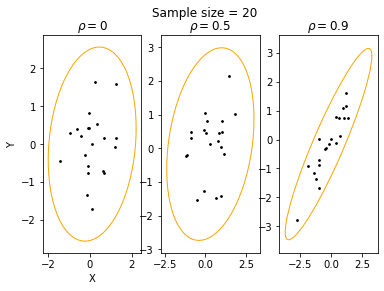

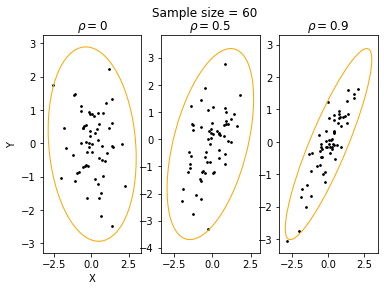

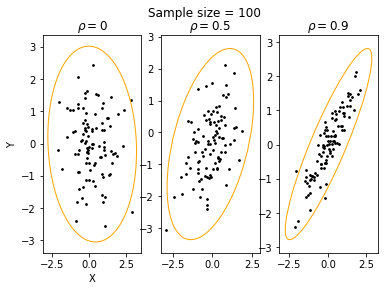

In [6]:
samples = []
for sample_size in sample_sizes:
    for rho in rhos:
        samples.append(get_random_variables_value(sample_size, rho, False))
    plot_ellipses(samples)
    samples = []

In [7]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
from matplotlib import pyplot as plt

sample_size = 20
bounds = -1.8, 2
step = 0.2
mu, sigma_squared = 0, 1
coefs = 2, 2
perturbations = [10, -10]


def leastSquares(x, y):
    b_ls = (np.mean(x * y) - np.mean(x) * np.mean(y)) / (np.mean(x * x) - np.mean(x) ** 2)
    a_ls = np.mean(y) - b_ls * np.mean(x)
    return a_ls, b_ls


def leastModulo(x, y, initial_guess):
    functionToMinimize = lambda beta: np.sum(np.abs(y - beta[0] - beta[1] * x))
    result = opt.minimize(functionToMinimize, initial_guess)
    a_lm = result['x'][0]
    b_lm = result['x'][1]
    return a_lm, b_lm


def coefficientEstimates(x, y):
    a_ls, b_ls = leastSquares(x, y)
    a_lm, b_lm = leastModulo(x, y, np.array([0, 0]))
    return a_ls, b_ls, a_lm, b_lm


def printEstimates(type, estimates):
    a_ls, b_ls, a_lm, b_lm = estimates
    print(type)
    print("Least Squares - МНК")
    print('a_ls = ' + str(np.around(a_ls, decimals=2)))
    print('b_ls = ' + str(np.around(b_ls, decimals=2)))
    print("Least Modulo - МНМ")
    print('a_lm = ' + str(np.around(a_lm, decimals=2)))
    print('b_lm = ' + str(np.around(b_lm, decimals=2)))

    
    
def criteriaComparison(x, estimates):
    a_ls, b_ls, a_lm, b_lm = estimates
    model = lambda x: coefs[0] + coefs[1] * x
    # least squares criteria
    lsc = lambda x: a_ls + b_ls * x
    # least modulo criteria
    lmc = lambda x: a_lm + b_lm * x
    sum_ls, sum_lm = 0, 0
    for point in x:
        y_ls = lsc(point)
        y_lm = lmc(point)
        y_model = model(point)
        sum_ls += pow(y_model - y_ls, 2)
        sum_lm += pow(y_model - y_lm, 2)
    print("Least squares approximate better! - ", sum_ls, " < ", sum_lm) if sum_ls < sum_lm\
        else print("Least modulo approximates better! - ", sum_lm, " < ", sum_ls)





#for type in ['Without perturbations', 'With perturbations']:
#    estimates = coefficientEstimates(x, y)
#    printEstimates(type, estimates)
#    plotRegression(x, y, type, estimates)
#    criteriaComparison(x, estimates)
#    y[0] += perturbations[0]
#    y[-1] += perturbations[1]



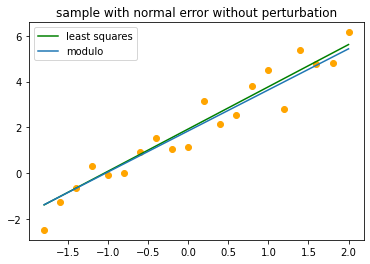

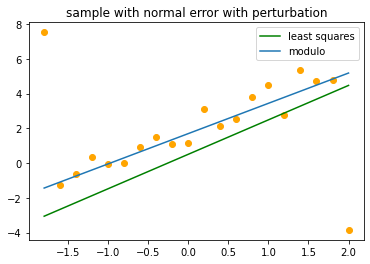

In [13]:
x = np.linspace(bounds[0], bounds[1], sample_size)
y = coefs[0] + coefs[1] * x + stats.norm(0, 1).rvs(sample_size)


a_s, b_s, a_m, b_m = coefficientEstimates(x, y)

plt.title('sample with normal error without perturbation')
plt.scatter(x, y, color='orange')
plt.plot(x, a_s * x + b_s, color='green', label = 'least squares')
plt.plot(x, a_m * x + b_m, label='modulo')
plt.legend()

plt.figure()
y[0] += 10
y[-1] -= 10

a_s, b_s, a_m, b_m = coefficientEstimates(x, y)

plt.title('sample with normal error with perturbation')
plt.scatter(x, y, color='orange')
plt.plot(x, a_s * x + b_s, color='green', label='least squares')
plt.plot(x, a_m * x + b_m, label='modulo')
plt.legend()

In [9]:

criteriaComparison(x, [a_s, b_s, a_m, b_m])

Least modulo approximates better! -  0.2665170056193474  <  51.424343628615674


In [10]:
import numpy as np

import scipy.stats as stats

start_border, end_border = -1.5, 1.5
sample_size = 20
alpha = 0.05
p = 1 - alpha
k = 5


def MLE(sample):
    """
        Calculates maximum likelihood estimations
        of μ, σ for normally distributed variates.
    """
    mu_ml = np.mean(sample)
    sigma_ml = np.std(sample)
    print("mu_ml = ", np.around(mu_ml, decimals=2),
          " sigma_ml=", np.around(sigma_ml, decimals=2))
    return mu_ml, sigma_ml


def quantile_chi2(sample, mu, sigma):
    """
        Decides whether to accept the hypothesis that N(mu, sigma)
        describes the given sample using chi2 criteria.
        Calculates sample value of chi2 statistic for a given sample.
    """
    hypothesis = lambda x: stats.norm.cdf(x, loc=mu, scale=sigma)

    borders = np.linspace(start_border, end_border, num=k - 1)  # 𝑎0 = −∞, 𝑎𝑘 = +∞

    probabilities = np.array(hypothesis(start_border))
    quantities = np.array(len(sample[sample < start_border]))

    for i in range(k - 2):
        p_i = hypothesis(borders[i + 1]) - hypothesis(borders[i])
        probabilities = np.append(probabilities, p_i)
        n_i = len(sample[(sample < borders[i + 1]) & (sample >= borders[i])])
        quantities = np.append(quantities, n_i)

    probabilities = np.append(probabilities, 1 - hypothesis(end_border))
    quantities = np.append(quantities, len(sample[sample >= end_border]))

    chi2 = np.divide(
        np.multiply(
            (quantities - sample_size * probabilities),
            (quantities - sample_size * probabilities)
        ),
        probabilities * sample_size
    )

    quantile = stats.chi2.ppf(p, k - 1)
    isAccepted = True if quantile > np.sum(chi2) else False
    return chi2, isAccepted, borders, probabilities, quantities


def build_table(chi2, borders, probabilities, quantities):
    """
        Builds chi2 calculation table.
    """
    headers = ["$i$", "$\\Delta_i = [a_{i-1}, a_i)$", "$n_i$", "$p_i$",
               "$np_i$", "$n_i - np_i$", "$(n_i - np_i)^2/np_i$"]
    rows = []
    for i in range(0, len(quantities)):
        if i == 0:
            limits = ["$-\infty$", np.around(borders[0], decimals=2)]
        elif i == len(quantities) - 1:
            limits = [np.around(borders[-1], decimals=2), "$\infty$"]
        else:
            limits = [np.around(borders[i - 1], decimals=2), np.around(borders[i], decimals=2)]
        rows.append(
            [i + 1,
             limits,
             quantities[i],
             np.around(probabilities[i], decimals=4),
             np.around(probabilities[i] * sample_size, decimals=2),
             np.around(quantities[i] - sample_size * probabilities[i], decimals=2),
             np.around(chi2[i], decimals=2)]
        )
    rows.append(["\\sum", "--", np.sum(quantities), np.around(np.sum(probabilities), decimals=4),
                 np.around(np.sum(probabilities * sample_size), decimals=2),
                 -np.around(np.sum(quantities - sample_size * probabilities), decimals=2),
                 np.around(np.sum(chi2), decimals=2)]
    )
    return rows, headers



normal_sample = np.random.normal(0, 1, size=sample_size)
mu_ml, sigma_ml = MLE(normal_sample)
chi2, isAccepted, borders, probabilities, quantities = quantile_chi2(normal_sample, mu_ml, sigma_ml)
print(build_table(chi2, borders, probabilities, quantities))
print("Hypothesis Accepted!") if isAccepted else print("Hypothesis Not Accepted!")


mu_ml =  0.08  sigma_ml= 0.84
([[1, ['$-\\infty$', -1.5], 0, 0.0298, 0.6, -0.6, 0.6], [2, [-1.5, -0.5], 5, 0.215, 4.3, 0.7, 0.11], [3, [-0.5, 0.5], 9, 0.4473, 8.95, 0.05, 0.0], [4, [0.5, 1.5], 5, 0.2628, 5.26, -0.26, 0.01], [5, [1.5, '$\\infty$'], 1, 0.0451, 0.9, 0.1, 0.01], ['\\sum', '--', 20, 1.0, 20.0, -0.0, 0.73]], ['$i$', '$\\Delta_i = [a_{i-1}, a_i)$', '$n_i$', '$p_i$', '$np_i$', '$n_i - np_i$', '$(n_i - np_i)^2/np_i$'])
Hypothesis Accepted!
